# IQ Loopback Example

This is simple IQ loopback test program.

## QICK Pyro4 Instanctiation

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import time

from qick import *
from qick.averager_program import QickSweep
from qick.pyro import make_proxy

# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

# Set DAC Channel 0 attenuation 20 dB and 20 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,31,31)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 20 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_9d369bee84084fc19b57abe94672fcca@192.168.2.99:42971


## Program

In [41]:
class IQ_LoopBackTest(NDAveragerProgram):
    def initialize(self):
        self.phrst = 0
        freq_rf     = 540
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = self.cfg["pulse_length"]  # Readout length
        )

        self.r_gain  = self.get_gen_reg(gen_ch = 0, name = "gain")
        self.r_phase = self.get_gen_reg(gen_ch = 0, name = "phase")
        self.add_sweep(
            QickSweep(
                prog    = self,
                reg     = self.r_gain,
                start   = 300,
                stop    = 900,
                expts   = 4,
                label   = "gain_sweep"
            )
        )
        self.add_sweep(
            QickSweep(
                prog    = self,
                reg     = self.r_phase,
                start   = 0,
                stop    = 315,
                expts   = 8,
                label   = "phase_sweep"
            )
        )
        # Convert RF frequency to DAC DDS register value
        freq_dac    = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )

        # Set DAC DDS
        self.set_pulse_registers(
            ch      = 0,        # Generator channel
            style   = "const",  # Output is gain * DDS output
            freq    = freq_dac, # Generator DDS frequency
            phase   = 45,        # Generator DDS phase
            gain    = 5000,     # Generator amplitude
            length  = self.cfg["pulse_length"],     # Pulse length
            phrst   = self.phrst# Generator DDS phase reset
        )
        # Set ADC DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = freq_adc, # Readout DDS frequency
            length  = self.cfg["pulse_length"],      # Readout DDS multiplication length
            phrst   = self.phrst# Readout DDS phase reset
        )
        self.synci(500)

    def body(self):
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 50        # Pulse will be output @ sync_t + 100
        )
        self.readout(
            ch      = 0,        # Readout channel
            t       = 50        # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        self.trigger(
            adcs    = [0],      # Readout channels
            adc_trig_offset = 150 # Readout will capture the data @ sync_t + 50
        )
        self.sync_all(5000)

## Execution

  0%|          | 0/320000 [00:00<?, ?it/s]


// Program

                  regwi 0, $22, 483183821;      //freq = 483183821
                  regwi 0, $23, 45;             //phase = 45
                  regwi 0, $25, 5000;           //gain = 5000
                  regwi 0, $26, 590824;         //phrst| stdysel | mode | | outsel = 0b01001 | length = 1000 
                  regwi 4, $22, 966367642;      //freq = 966367642
                  regwi 4, $26, 1000;           //mode | outsel = 0b00000 | length = 1000 
                  synci 500;
                  regwi 0, $13, 0;
                  regwi 0, $14, 9999;
LOOP_rep:         regwi 0, $23, 0;              //'gen0_phase' <= 0 (0 deg)
                  regwi 0, $18, 7;
LOOP_phase_sweep: regwi 0, $25, 300;            //'gen0_gain' <= 300 
                  regwi 0, $17, 3;
LOOP_gain_sweep:  regwi 0, $27, 50;             //t = 50
                  set 0, 0, $22, $23, $0, $25, $26, $27;//ch = 0, pulse @t = $27
                  regwi 4, $27, 50;             //t = 50
                

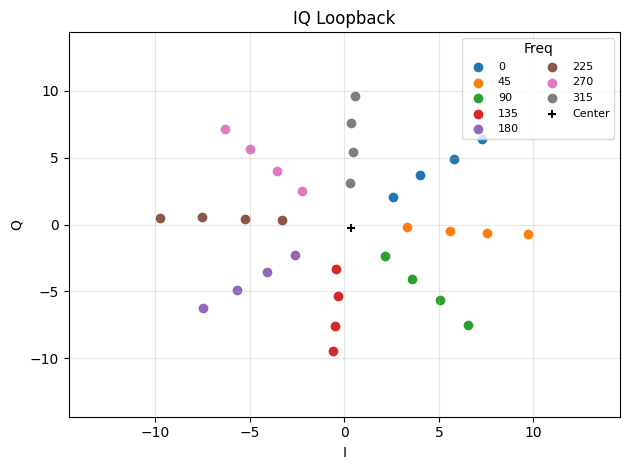

In [42]:
prog = IQ_LoopBackTest(
    soccfg,
    {
        "reps" : 10000,
        "expts" : 1,
        "pulse_length" : 1000,
    }
)
start_time = time.time()
expt_pts, avg_di, avg_dq = prog.acquire(soc, progress=True, start_src = "internal")
end_time = time.time()

total_time = end_time - start_time
print(prog)
print(f"total time : {total_time} s")

c_x = 0
c_y = 0

plt.figure()
for j, phase in enumerate(expt_pts[1]):
    plt.scatter(avg_di[0][0][j], avg_dq[0][0][j], label=f"{int(phase)}")
    c_x = c_x + np.sum(avg_di[0][0][j])
    c_y = c_y + np.sum(avg_dq[0][0][j])
plt.scatter(c_x,c_y, label="Center", color='k', marker='+')
plt.title("IQ Loopback")
plt.xlabel("I")
plt.ylabel("Q")
xmax = np.max(np.abs(avg_di[0][0]))
ymax = np.max(np.abs(avg_dq[0][0]))

plt.xlim([-xmax * 1.5, xmax * 1.5])
plt.ylim([-ymax * 1.5, ymax * 1.5])
plt.grid(True, alpha=0.3)
plt.legend(title="Freq", ncol=2, fontsize=8)
plt.tight_layout()
plt.show()